# ゼロから始める線形回帰

高性能な機械学習のライブラリは単純な問題をいとも簡単に解いてしまうでしょうが、中身の見えないライブラリに頼りすぎると、ニューラルネットワークがどのように動いているのか詳細を知ることは決してできないでしょう。まず最初に、自ら手を動かして、ゼロから全てを構築してみましょう。ここで利用してよいのはautogradとNDArrayのみとします。まず、[autograd chapter](../chapter01_crashcourse/autograd.ipynb)の章にあったように、必要なライブラリをインポートします。強力な`gluon`もインポートするのですが、今回はデータの読み込みにだけ利用します。

<!-- 
Powerful ML libraries can eliminate repetitive work, but if you rely too much on abstractions, you might never learn how neural networks really work under the hood. So for this first example, let's get our hands dirty and build everything from scratch, relying only on autograd and NDArray. First, we'll import the same dependencies as in the [autograd chapter](../chapter01_crashcourse/autograd.ipynb). We'll also import the powerful `gluon` package  but in this chapter, we'll only be using it for data loading. -->

In [5]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon
mx.random.seed(1)

## contextのセット

計算が実際に行われるcontextを指定しようと思います。このチュートリアルはシンプルなので、calculator watchでも実行できると思います。しかし、より良いやり方を学ぶためにも、ここでは2つのcontextを指定します。1つはデータ用、もう1つはモデル用です。

<!-- 
We'll also want to specify the contexts where computation should happen. This tutorial is so simple that you could probably run it on a calculator watch. But, to develop good habits we're going to specify two contexts: one for data and one for our models.  -->

In [7]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

## 線形回帰

まず回帰問題を見ることからはじめます。これは、データ点$x$が与えられたときに、*実数の回帰対象*$y$を予測するタスクです。最も単純でありながら、現在も有用な方法である線形回帰では、予測値は入力されたデータの*線形*結合で表現されると仮定します（なので、*線形*回帰という名前がついています）。

<!-- 
To get our feet wet, we'll start off by looking at the problem of regression.
This is the task of predicting a *real valued target* $y$ given a data point $x$.
In linear regression, the simplest and still perhaps the most useful approach,
we assume that prediction can be expressed as a *linear* combination of the input features 
(thus giving the name *linear* regression):
 -->

$$\hat{y} = w_1 \cdot x_1 + ... + w_d \cdot x_d + b$$

データ点の集合$X$と対応する回帰対象$\boldsymbol{y}$が与えられたときに、データ点$\boldsymbol{x}_i$と対応するラベル$y_i$との関係を近似的に表現する*重み*のベクトル
$\boldsymbol{w}$とバイアス$b$（オフセットや切片とも呼ばれます）を探します。もう少し数学的な記法を使うなら、予測値$\boldsymbol{\hat{y}}$と対応するデータ点の集合$X$を行列とベクトルの乗算で以下の用に表現できます。

$$\boldsymbol{\hat{y}} = X \boldsymbol{w} + b$$

<!-- 

Given a collection of data points $X$, and corresponding target values $\boldsymbol{y}$, 
we'll try to find the *weight* vector $\boldsymbol{w}$ and bias term $b$ 
(also called an *offset* or *intercept*)
that approximately associate data points $\boldsymbol{x}_i$ with their corresponding labels ``y_i``. 
Using slightly more advanced math notation, we can express the predictions $\boldsymbol{\hat{y}}$
corresponding to a collection of datapoints $X$ via the matrix-vector product:

$$\boldsymbol{\hat{y}} = X \boldsymbol{w} + b$$ -->

線形回帰へと進む前に、以下の2つが必要になります。

* 現在のモデルの良さを測る方法
* モデルがより良くなるように、モデルを操作する方法

<!-- Before we can get going, we will need two more things 

* Some way to measure the quality of the current model  
* Some way to manipulate the model to improve its quality
 -->

### 二乗誤差

モデルが良いかどうかを述べるためには、そのモデルの良さを図る方法が必要になります。一般的には、予測が正解からどれだけ離れているかを表す*ロス関数*を定義します。古くから行われている線形回帰では、通常、二乗誤差を利用します。具体的には、ロスはすべてのデータ点に対して、二乗誤差$(y_i-\hat{y})^2$の和をとったもので、以下のように示されます。
<!-- 
In order to say whether we've done a good job, 
we need some way to measure the quality of a model. 
Generally, we will define a *loss function*
that says *how far* are our predictions from the correct answers.
For the classical case of linear regression, 
we usually focus on the squared error.
Specifically, our loss will be the sum, over all examples, of the squared error $(y_i-\hat{y})^2$ on each: -->

$$\ell(y, \hat{y}) = \sum_{i=1}^n (\hat{y}_i-y_i)^2.$$

1次元のデータであれば、単一の特徴と回帰対象の関係を簡単に可視化できます。つまり、線形回帰式と、データ点ごとの誤差を可視化することができます。二乗誤差は*外れ値の影響を非常に受ける*ということに注意してください。以下の可視化した線形回帰式をみると、たった一つの外れ値が大きなロスにつながっています。

<!-- 
For one-dimensional data, we can easily visualize the relationship between our single feature and the target variable. It's also easy to visualize a linear predictor and it's error on each example. 
Note that squared loss *heavily penalizes outliers*. For the visualized predictor below, the lone outlier would contribute most of the loss.
 -->
 
![](../img/linear-regression.png)


### モデルに対する操作

誤差を最小化するためには、モデルを改良していく仕組みが必要です。これは*パラメータ*の
$\boldsymbol{w}$と$b$の値を上手く選ぶことによって実現され、学習アルゴリズムが行います。学習データを($X$, $y$)、モデルの関数を$\hat{y} = X\boldsymbol{w} + b$とおくと、学習とは利用可能なデータにもとづいて$\boldsymbol{w}$と$b$を決定することです。

<!-- For us to minimize the error,
we need some mechanism to alter the model.
We do this by choosing values of the *parameters*
$\boldsymbol{w}$ and $b$.
This is the only job of the learning algorithm.
Take training data ($X$, $y$) and the functional form of the model $\hat{y} = X\boldsymbol{w} + b$.
Learning then consists of choosing the best possible $\boldsymbol{w}$ and $b$ based on the available evidence. -->


### 歴史的経緯

ひょっとすると、線形回帰が古くからの統計的モデルであることをご存知のかたもいるかもしれません。[Wikipediaによれば](https://en.wikipedia.org/wiki/Regression_analysis#History)、ルジャンドルが1805年に最小二乗法を開発し、のちの1809年にガウスが再発見しました。推測が入りますが、何度か最小二乗法の論文について話していたルジャンドルは、ガウスが彼の論文を引用しないことにいらだっていたそうです。

<!-- 
You might reasonably point out that linear regression is a classical statistical model.
[Wikipediaによれば](https://en.wikipedia.org/wiki/Regression_analysis#History),
Legendre first developed the method of least squares regression in 1805,
which was shortly thereafter rediscovered by Gauss in 1809. 
Presumably, Legendre, who had Tweeted about the paper several times,
was peeved that Gauss failed to cite his arXiv preprint. 
 -->
 
![Legendre](../img/legendre.jpeg)

起源についての話はさておいて、ルジャンドルとガウスが線形回帰についての仕事をしていたら、それが最初のDeep Learningの研究者になったかもしれない、と思うかもしれません。もし、線形回帰がDeep Learningに属さないのであれば、なぜニューラルネットワークのチュートリアルの最初に線形モデルを持ってきたのでしょうか。実は、線形回帰は、最も単純で有効なニューラルネットワークとして表現されることがわかっています。ニューラルネットワークは、向きのあるエッジでつながった、ノード（別名ニューロン）の集合です。たいていのネットワークは、ノードの集合をさらにレイヤとし、各レイヤからの出力はさらに上のレイヤへと入力されていきます。ノードの値を計算するためには、ノードへの入力の重み付け和を計算し（重みは$w$とする）、*活性化関数*を適用します。線形回帰の場合は2つのレイヤを利用します。1つは入力（オレンジで図示）と、もう1つは出力に対応する1ノードのレイヤ（緑で図示）です。出力ノードのための活性化関数は、値をそのまま返す関数を利用します。

<!-- Matters of provenance aside, you might wonder - if Legendre and Gauss 
worked on linear regression, does that mean there were the original deep learning researchers?
And if linear regression doesn't wholly belong to deep learning, 
then why are we presenting a linear model 
as the first example in a tutorial series on neural networks? 
Well it turns out that we can express linear regression 
as the simplest possible (useful) neural network. 
A neural network is just a collection of nodes (aka neurons) connected by directed edges. 
In most networks, we arrange the nodes into layers with each feeding its output into the layer above. 
To calculate the value of any node, we first perform a weighted sum of the inputs (according to weights ``w``) 
and then apply an *activation function*. 
For linear regression, we only have two layers, one corresponding to the input (depicted in orange) 
and a one-node layer (depicted in green) corresponding to the ouput.
For the output node the activation function is just the identity function. -->

![](../img/onelayer.png)

Deep Learningの観点から線形回帰を見る必要はありませんが、そういった見方をすることはできます（そういうふうに見ていきたいと思います）。議論したようなコンセプトをコードでしっかりと理解するために、実際にゼロから線形回帰のニューラルネットワークのコードを書いてみましょう。

<!-- 
While you certainly don't have to view linear regression through the lens of deep learning, 
you can (and we will!).
To ground the concepts that we just discussed in code, 
let's actually code up a neural network for linear regression from scratch. -->

進めるにあたって単純な合成データセットをつくります。データセットは、データ点``X[i]``と対応するラベル``y[i]``について、次のようなランダムサンプリングで作ります。入力は、平均が$0$で分散が$1$の正規分布からサンプリングします。特徴量は互いに独立で、別の言い方をすればdiagonal covariance (対角成分のみ共分散が存在する)となります。ラベルは`y[i] = 2 * X[i][0]- 3.4 * X[i][1] + 4.2 + noise` の計算式で決定します。`noise`は平均が$0$、分散が$.01$であるような正規分布からサンプリングします。ラベルを決定する式について、もう少し数学的に書くと以下のようになります。

<!-- 
To get going, we will generate a simple synthetic dataset by sampling random data points ``X[i]`` and corresponding labels ``y[i]`` in the following manner. Our inputs will each be sampled from a random normal distribution with mean $0$ and variance $1$. Our features will be independent. Another way of saying this is that they will have diagonal covariance.  The labels will be generated accoding to the *true* labeling function `y[i] = 2 * X[i][0]- 3.4 * X[i][1] + 4.2 + noise` where the noise is drawn from a random gaussian with mean ``0`` and variance ``.01``. We could express the labeling function in mathematical notation as: -->

$$y = X \cdot w + b + \eta, \quad \text{for } \eta \sim \mathcal{N}(0,\sigma^2)$$ 


In [8]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2
    
X = nd.random_normal(shape=(num_examples, num_inputs), ctx=data_ctx)
noise = .1 * nd.random_normal(shape=(num_examples,), ctx=data_ctx)
y = real_fn(X) + noise

``X``の各行は2次元のデータ点で、``Y``の各行は1次元の回帰対象の値になります。

<!-- Notice that each row in ``X`` consists of a 2-dimensional data point and that each row in ``Y`` consists of a 1-dimensional target value.  -->

In [9]:
print(X[0])
print(y[0])


[ 0.03629481 -0.4902442 ]
<NDArray 2 @cpu(0)>

[6.0096445]
<NDArray 1 @cpu(0)>


合成データ`X`は`data_ctx`の上で動いていること、noiseもまた`data_ctx`の上で動いていることから、`X`と`noise`の組み合わせとして`real_fn`で計算されるラベル`y`もまた`data_ctx`上で動きます。ランダムに選択した点に対して、既知の最適なパラメータ（=ラベルを決定する式の係数）であれば、回帰対象のラベルに非常に近い予測をすることができます。

<!-- Note that because our synthetic features `X` live on `data_ctx` and because our noise also lives on `data_ctx`, the labels `y`, produced by combining `X` and `noise` in `real_fn` also live on `data_ctx`. 
We can confirm that for any randomly chosen point, 
a linear combination with the (known) optimal parameters 
produces a prediction that is indeed close to the target value -->

In [10]:
print(2 * X[0, 0] - 3.4 * X[0, 1] + 4.2)


[5.9394197]
<NDArray 1 @cpu(0)>


``matplotlib``というPythonのグラフ作成ライブラリを利用して散布図を作ることで、2番目の特徴(``X[:, 1]``)と回帰対象``Y``の対応を可視化することができます。``matplotlib``がインストールされていることを確認してください。もしインストールされていなければ、コマンドラインで``pip2 install matplotlib`` (Python 2の場合)や``pip3 install matplotlib`` (Python 3の場合)とするとインストールできると思います。``matplotlib``で散布図を作成するには、``.asnumpy()``とという関数を利用して、``X``と``y``をNumpy arrayの形式に変換する必要があります。

<!-- We can visualize the correspondence between our second feature (``X[:, 1]``) and the target values ``Y`` by generating a scatter plot with the Python plotting package ``matplotlib``. Make sure that ``matplotlib`` is installed. Otherwise, you may install it by running ``pip2 install matplotlib`` (for Python 2) or ``pip3 install matplotlib`` (for Python 3) on your command line. 

In order to plot with ``matplotlib`` we'll just need to convert ``X`` and ``y`` into NumPy arrays by using the `.asnumpy()` function.  -->

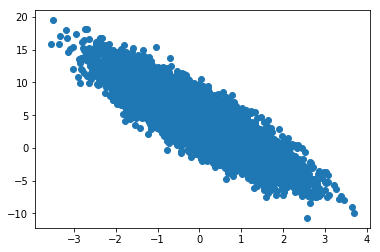

In [29]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1].asnumpy(),y.asnumpy())
plt.show()

## データイテレータ

ニューラルネットワークを利用し始めると、データポイント全体を速く回して処理したくなると思います。例えば、ある時点において``k``個のデータのかたまりを取り出したり、データをシャッフルしたりする場合などがあります。MXNetのデータイテレータは、データの取り出しと加工について素晴らしい機能をいくつも提供しています。特に、シンプルな``DataLoader``クラスを使うことがあると思います。これは、学習するときに直感的に利用できる``ArrayDataset``を提供しています。

<!-- Once we start working with neural networks, we're going to need to iterate through our data points quickly. We'll also want to be able to grab batches of ``k`` data points at a time, to shuffle our data. In MXNet, data iterators give us a nice set of utilities for fetching and manipulating data. In particular, we'll work with the simple  ``DataLoader`` class, that provides an intuitive way to use an ``ArrayDataset`` for training models.
 -->

`gluon.data.ArrayDataset(X, y)`を呼び出せば、`X`と`y`を`ArrayDataset`に読み出すことができます。`X`が例えば画像のような多次元で、`y`がラベルの1次元配列であっても問題ありません。一つ守るべきこととしては、それらは第1の軸に沿って同じ長さである必要があります。つまり`len(X) == len(y)`です。
<!-- 

We can load `X` and `y` into an ArrayDataset, by calling `gluon.data.ArrayDataset(X, y)`. It's ok for `X` to be a multi-dimensional input array (say, of images) and `y` to be just a one-dimensional array of labels. The one requirement is that they have equal lengths along the first axis, i.e., `len(X) == len(y)`.  -->

`ArrayDataset`が与えられれば、`ArrayDataset`からランダムにバッチ（データの集まり）をとってくる`DataLoader`を作ることができます。その際、2つの引数が必要になります。まず1つ目は`batch_size`で一度にいくつのデータ点をとってくるかです。2つ目は、データセットからデータを反復的に取るなかで、そのデータをシャッフルするかどうかです。

<!-- 
Given an `ArrayDataset`, we can create a DataLoader which will grab random batches of data from an `ArrayDataset`.  We'll want to specify two arguments. First, we'll need to say the `batch_size`, i.e., how many examples we want to grab at a time. Second, we'll want to specify whether or not to shuffle the data between iterations through the dataset.  -->

In [11]:
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y),
                                   batch_size=batch_size, shuffle=True)

DataLoader (``train_data``)をいったん初期化してしまえば、Pythonのリストであるかのように、`train_data`から繰り返しバッチをとることが簡単に行なえます。好きな反復方法を利用することもできて、foreachであれば`for data, label in train_data`、enumerationsであれば`for i, (data, label) in enumerate(train_data)`となります。以下では1つのバッチを取り出して、すぐにループから抜けてみます。

<!-- Once we've initialized our DataLoader (``train_data``), we can easily fetch batches by iterating over `train_data` just as if it were a Python list. You can use your favorite iterating techniques like foreach loops: `for data, label in train_data` or enumerations: `for i, (data, label) in enumerate(train_data)`. 
First, let's just grab one batch and break out of the loop. -->

In [12]:
for i, (data, label) in enumerate(train_data):
    print(data, label)
    break


[[-1.1692905 -1.1564009]
 [-0.6558346 -1.1515095]
 [-1.3683952 -1.3929751]
 [ 0.8618017  0.9700353]]
<NDArray 4x2 @cpu(0)> 
[5.537754  6.781127  6.1318207 2.5336356]
<NDArray 4 @cpu(0)>


同じコードを再び動かしたとしても、異なるバッチが得られることに気づくと思います。これは`DataLoader`において、`shuffle=True`としているためです。

<!-- 
If we run that same code again you'll notice that we get a different batch. That's because we instructed the `DataLoader` that `shuffle=True`.  -->

In [13]:
for i, (data, label) in enumerate(train_data):
    print(data, label)
    break


[[ 0.53092563  0.49279854]
 [-0.38172382 -0.21867985]
 [ 0.31303582  0.6013608 ]
 [-0.6820405  -0.08011921]]
<NDArray 4x2 @cpu(0)> 
[3.4612846 4.187644  2.841288  3.02776  ]
<NDArray 4 @cpu(0)>


最後に、もしデータセット全体を渡していたとしたら、バッチの数を数えてみてください。2,500バッチあることに気づくと思います。10,000のデータに対して、`DataLoader`のバッチサイズを4にしているので、このバッチの数を計算することができます。

<!-- Finally, if we actually pass over the entire dataset, and count the number of batches, we'll find that there are 2500 batches. We expect this because our dataset has 10,000 examples and we configured the `DataLoader` with a batch size of 4. -->

In [33]:
for i, (data, label) in enumerate(train_data):
    pass
print(i+1)

2500


## モデルのパラメータ

パラメータのためのメモリを確保して初期値をセットしましょう。パラメータの初期化も`model_ctx`上で行います。

<!-- Now let's allocate some memory for our parameters and set their initial values. We'll want to initialize these parameters on the `model_ctx`.  -->

In [34]:
w = nd.random_normal(shape=(num_inputs, num_outputs), ctx=model_ctx)
b = nd.random_normal(shape=num_outputs, ctx=model_ctx)
params = [w, b]

続くセルでは、データにより適合するように、これらのパラメータを更新していきます。これには、パラメータに関して*ロス関数*の勾配を計算する（つまり多次元の微分）が必要になります。ロスを減少させる方向へとパラメータを更新します。しかし、まずは勾配のためのメモリを確保します。

<!-- In the succeeding cells, we're going to update these parameters to better fit our data. This will involve taking the gradient (a multi-dimensional derivative) of some *loss function* with respect to the parameters. We'll update each parameter in the direction that reduces the loss. But first, let's just allocate some memory for each gradient. -->

In [35]:
for param in params:
    param.attach_grad()

## ニューラルネットワーク

次にモデルを定義します。今回の場合、最も単純で*有用な*線形回帰のモデルを対象としています。線形モデルの出力を計算するために、与えられた入力とモデルの重み(``w``)を掛け算して、オフセット``b``を加えます。

<!-- Next we'll want to define our model. In this case, we'll be working with linear models, the simplest possible *useful* neural network. To calculate the output of the linear model, we simply multiply a given input with the model's weights (``w``), and add the offset ``b``. -->

In [36]:
def net(X):
    return mx.nd.dot(X, w) + b

これは簡単ですね。

## ロス関数

モデルの学習では、学習の期間が過ぎていくとともに、モデルを良くしていくことを目的としています。この目的をもっと具体化するために、まずは*良い*ということを定義する必要があります。この場合、予測値と実際の値との二乗誤差を利用します。

<!-- Train a model means making it better and better over the course of a period of training. But in order for this goal to make any sense at all, we first need to define what *better* means in the first place. In this case, we'll use the squared distance between our prediction and the true value.  -->

In [37]:
def square_loss(yhat, y): 
    return nd.mean((yhat - y) ** 2)

## 最適化手法

線形回帰は実はclosed-formな解をもっており、行列の演算によって解析的に求めることが可能です。しかし、多くの人が興味をもつようなモデルというのは解析的に解くことはできません。そこで、Stochastic Gradient Descent (確率的勾配降下法)を利用します。各ステップにおいて、データセットからランダムサンプリングしたバッチを利用して、重みに対するロスの勾配を計算します。そして、ロスを減少させる方向へと少しパラメータを変化させます。その変化の大きさは学習率``lr``によって決定します。

<!-- It turns out that linear regression actually has a closed-form solution. However, most interesting models that we'll care about cannot be solved analytically. So we'll solve this problem by stochastic gradient descent. At each step, we'll estimate the gradient of the loss with respect to our weights, using one batch randomly drawn from our dataset. Then, we'll update our parameters a small amount in the direction that reduces the loss. The size of the step is determined by the *learning rate* ``lr``.  -->

In [38]:
def SGD(params, lr):    
    for param in params:
        param[:] = param - lr * param.grad

## 学習ループの実行

さて全ての必要なピースがそろったところで、学習ループを書いて、それらをつなげる必要があります。まずは、データセットをモデルに入力する回数であるエポック``epoch``を決めます。データセットを入力するたびに、``train_data``からデータと対応するラベルのバッチを反復的に取り出します。各バッチでは、次のような処理を行います。

* データをネットワークに入力して前向きに実行し、予測値``yhat``とロス``loss``を計算
* ネットワークの最後から勾配を順番に逆方向に計算 (``loss.backward()``)
* SGDの最適化手法を利用してモデルのパラメータを更新

<!-- Now that we have all the pieces, we just need to wire them together by writing a training loop. 
First we'll define ``epochs``, the number of passes to make over the dataset. Then for each pass, we'll iterate through ``train_data``, grabbing batches of examples and their corresponding labels. 

For each batch, we'll go through the following ritual:
     
* Generate predictions (``yhat``) and the loss (``loss``) by executing a forward pass through the network.
* Calculate gradients by making a backwards pass through the network (``loss.backward()``). 
* Update the model parameters by invoking our SGD optimizer.      -->


In [39]:
epochs = 10
learning_rate = .0001
num_batches = num_examples/batch_size

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1, 1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()
    print(cumulative_loss / num_batches)

24.6606138554
9.09776815639
3.36058844271
1.24549788469
0.465710770596
0.178157229481
0.0721970594548
0.0331197250206
0.0186954441286
0.0133724625537


## 学習プロセスの可視化

以降の章では、もっと現実的なデータ、高等なモデル、複雑なロス関数、などを扱います。しかし、根本的な考え方は同じで、学習ループはどこでもみかけます。これらのチュートリアルは単体で完結するので、ここで述べた処理について理解が深まっていくと思います。モデルを更新するだけではなく、その内容を記録しておきたいと考えるようになると思います。また、学習の進捗をトラッキングしたり、可視化したいと思うかもしれません。そこで、ちょっと洗練された学習ループについて以下で紹介したいと思います。
<!-- 
In the succeeding chapters, we'll introduce more realistic data, fancier models, more complicated loss functions, and more. But the core ideas are the same and the training loop will look remarkably familiar. Because these tutorials are self-contained, you'll get to know this ritual quite well. In addition to updating our model, we'll often want to do some bookkeeping. Among other things, we might want to keep track of training progress and visualize it graphically. We demonstrate one slighly more sophisticated training loop below. -->

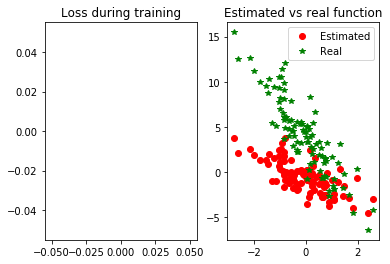

Epoch 0, batch 2499. Mean loss: 16.9325145943
Epoch 1, batch 2499. Mean loss: 6.24987681103
Epoch 2, batch 2499. Mean loss: 2.31109857569
Epoch 3, batch 2499. Mean loss: 0.858666448605
Epoch 4, batch 2499. Mean loss: 0.323071002489
Epoch 5, batch 2499. Mean loss: 0.125603744188
Epoch 6, batch 2499. Mean loss: 0.0527891687471
Epoch 7, batch 2499. Mean loss: 0.0259436405713
Epoch 8, batch 2499. Mean loss: 0.0160523827007
Epoch 9, batch 2499. Mean loss: 0.0124009371101


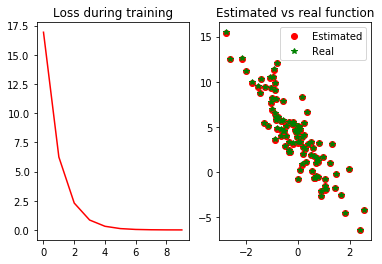

In [41]:
############################################
#    Re-initialize parameters because they 
#    were already trained in the first loop
############################################
w[:] = nd.random_normal(shape=(num_inputs, num_outputs), ctx=model_ctx)
b[:] = nd.random_normal(shape=num_outputs, ctx=model_ctx)

############################################
#    Script to plot the losses over time
############################################
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             net(X[:sample_size, :]).asnumpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             real_fn(X[:sample_size, :]).asnumpy(), '*g', label='Real')
    fg2.legend()

    plt.show()

learning_rate = .0001
losses = []
plot(losses, X)

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1, 1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()

    print("Epoch %s, batch %s. Mean loss: %s" % (e, i, cumulative_loss/num_batches))
    losses.append(cumulative_loss/num_batches)
            
plot(losses, X)

## まとめ

mxnet.ndarrayやmxnet.autogradを利用して、ゼロから統計モデルを構築する方法を紹介しました。次のチュートリアルでは、この基礎にもとづいて、最新のニューラルネットワークの基本的なアイデアや、そのようなモデルをMXNetの`gluon`を用いて、わずかなコードで非常に抽象的な記述ができることぉ紹介します。

<!-- You've seen that using just mxnet.ndarray and mxnet.autograd, we can build statistical models from scratch. In the following tutorials, we'll build on this foundation, introducing the basic ideas behind modern neural networks and demonstrating the powerful abstractions in MXNet's `gluon` package for building complex models with little code.  -->

## 次は
[gluonを利用した線形回帰](../chapter02_supervised-learning/linear-regression-gluon.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)